### File for detecting depression

#### Importing libraries

In [1]:
import re
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.corpus import stopwords
from keras.models import Sequential
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, LSTM, Dropout, Activation, SpatialDropout1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score
%matplotlib inline

Using TensorFlow backend.


#### Data merging

In [2]:
# Reading dataset
depression_tweets_df1 = pd.read_csv('../dataset/depression-tweets.csv')
depression_tweets_df2 = pd.read_csv('../dataset/depression-tweet.csv')
depression_tweets_df3 = pd.read_csv('../dataset/depress.csv')
depression_df4 = pd.read_csv('../dataset/depression-data.csv')

depression_tweets_df = depression_tweets_df1.append(depression_tweets_df2)
depression_tweets_df = depression_tweets_df.append(depression_tweets_df3)
depression_tweets_df = depression_tweets_df.append(depression_df4)
depression_tweets_df['Label'] = 1

# Selecting only text and labeled class columns which relate to depression
depression_tweets_df = depression_tweets_df[['tweet', 'Label']]
depression_tweets_df.columns = ['Message', 'Label']

# Drop duplicates
depression_tweets_df = depression_tweets_df.drop_duplicates(subset = 'Message', keep = 'first')
depression_tweets_df.reset_index(inplace = True, drop = True)

# Sampling
depression_tweets_df = depression_tweets_df.sample(frac = 1, random_state = 200)
depression_tweets_df.reset_index(inplace = True, drop = True) 

depression_tweets_df.shape

/home/yash/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/yash/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


(71904, 2)

In [3]:
# Reading dataset
sentiment_dev_df = pd.read_csv('../dataset/sentiment_dev.csv', encoding ='latin-1', names = [1, 2, 3, 4, 5, 6])

# Selecting only text and labeled class columns
sentiment_dev_df = sentiment_dev_df.iloc[:, [5, 0]]
sentiment_dev_df.columns = ['Message', 'Label']
sentiment_dev_df['Label'] = 0

# Drop duplicates
sentiment_dev_df = sentiment_dev_df.drop_duplicates(subset = 'Message', keep = 'first')
sentiment_dev_df.reset_index(inplace = True, drop = True) 

# Sampling
sentiment_dev_df = sentiment_dev_df.sample(frac = 1, random_state = 400)
sentiment_dev_df.reset_index(inplace = True, drop = True)

sentiment_dev_df = sentiment_dev_df.sample(frac = 0.025 * 2, random_state = 200)
sentiment_dev_df.reset_index(inplace = True, drop = True) 

sentiment_dev_df.shape

(79073, 2)

In [4]:
# Merging all dataframes
df = depression_tweets_df.append([sentiment_dev_df], ignore_index=True)

# Drop duplicates
df = df.drop_duplicates(subset = 'Message', keep = 'first')
df.reset_index(inplace=True, drop=True)

# Shuffling data
df = df.sample(frac = 1)
df.reset_index(inplace=True, drop=True) 


print('The size of final dataframe is :', df.shape)

The size of final dataframe is : (150977, 2)


#### Data visualization

Text(0, 0.5, 'No of observations')

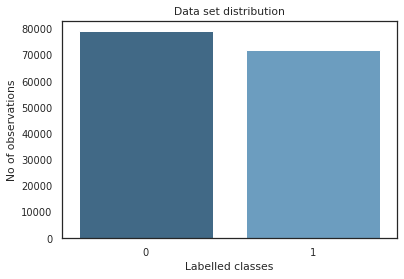

In [5]:
# No. of observation belonging to each labelled class
sns.set(style="white")
sns.set_context("notebook", font_scale=0.9)
depression_class_distribution = sns.countplot(x = "Label", data = df, palette = "Blues_d")
plt.title('Data set distribution')
plt.xlabel('Labelled classes')
plt.ylabel('No of observations')

#### Data preprocessing

In [6]:
def clean_text(text):
    
    # Remove puncuation
    text = text.translate(string.punctuation)
    
    # Convert words to lower case and split them
    text = text.lower().split()
    
    # Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    
    # Clean the text
    text = " ".join(text)    
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    
    # Stemming
    text = re.sub(r"\s{2,}", " ", text)
    
    text = text.split()
    
    # Convert similar words to a common root word
    stemmer = nltk.PorterStemmer()
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)
    
    return text

In [7]:
# Cleaning all text in dataframe
df['Message'] = df['Message'].map(lambda x: clean_text(x))

In [8]:
MAX_NB_WORDS = 5000
MAX_SEQUENCE_LENGTH = 200
EMBEDDING_DIM = 32
epochs = 8
batch_size = 64

In [9]:
def create_input_features(df):
    
    # Creating tokens from sentences
    tokenizer = Tokenizer(num_words = MAX_NB_WORDS)
    tokenizer.fit_on_texts(df['Message'].values)
    
    # Create sequences of words in a sentence
    sequences = tokenizer.texts_to_sequences(df['Message'].values)
    
    # Pad the sequences to create a common sentence size for all sentences
    X = pad_sequences(sequences, maxlen = MAX_SEQUENCE_LENGTH)
    
    y = df['Label'].values
    return (tokenizer, X, y)

#### Splitting data

In [10]:
(tokenizer, X, y) = create_input_features(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.08, random_state = 202)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.12, random_state = 202)

#### Visualizing train and test data

Text(0, 0.5, 'No of observations')

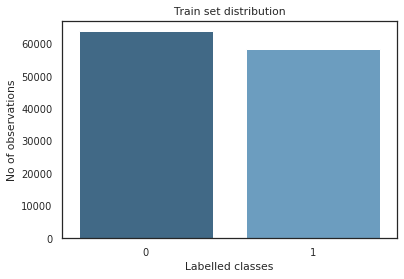

In [11]:
# No. of observation belonging to each labelled class in train set.
sns.set(style="white")
sns.set_context("notebook", font_scale = 0.9)
depression_class_distribution = sns.countplot(x = y_train, palette = "Blues_d")
plt.title('Train set distribution')
plt.xlabel('Labelled classes')
plt.ylabel('No of observations')

Text(0, 0.5, 'No of observations')

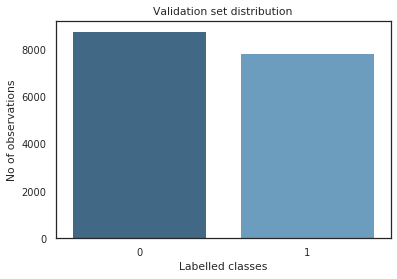

In [12]:
# No. of observation belonging to each labelled class in val set.
sns.set(style="white")
sns.set_context("notebook", font_scale = 0.9)
depression_class_distribution = sns.countplot(x = y_val, palette = "Blues_d")
plt.title('Validation set distribution')
plt.xlabel('Labelled classes')
plt.ylabel('No of observations')

Text(0, 0.5, 'No of observations')

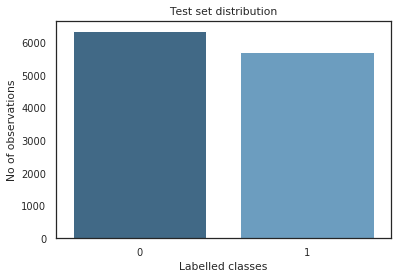

In [13]:
# No. of observation belonging to each labelled class in test set.
sns.set(style="white")
sns.set_context("notebook", font_scale=0.9)
depression_class_distribution = sns.countplot(x = y_test, palette="Blues_d")
plt.title('Test set distribution')
plt.xlabel('Labelled classes')
plt.ylabel('No of observations')

#### Model building

In [19]:
def create_model():
    model = Sequential()
    model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length = MAX_SEQUENCE_LENGTH))
    model.add(LSTM(2, return_sequences = False))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [20]:
model = create_model()
model_history = model.fit(X_train, y_train,
                          epochs = epochs,
                          batch_size = batch_size,
                          validation_data = (X_val, y_val),
                          callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2, min_delta = 0.002)])

/home/yash/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 122230 samples, validate on 16668 samples
Epoch 1/8
122230/122230 [==============================] - 153s 1ms/step - loss: 0.3074 - accuracy: 0.8416 - val_loss: 0.0974 - val_accuracy: 0.9789
Epoch 2/8
122230/122230 [==============================] - 153s 1ms/step - loss: 0.2368 - accuracy: 0.8621 - val_loss: 0.0826 - val_accuracy: 0.9792
Epoch 3/8
122230/122230 [==============================] - 151s 1ms/step - loss: 0.2273 - accuracy: 0.8675 - val_loss: 0.0793 - val_accuracy: 0.9793
Epoch 4/8
122230/122230 [==============================] - 152s 1ms/step - loss: 0.2204 - accuracy: 0.8695 - val_loss: 0.0749 - val_accuracy: 0.9797
Epoch 5/8
122230/122230 [==============================] - 155s 1ms/step - loss: 0.2178 - accuracy: 0.8702 - val_loss: 0.0721 - val_accuracy: 0.9803
Epoch 6/8
122230/122230 [==============================] - 146s 1ms/step - loss: 0.2155 - accuracy: 0.8692 - val_loss: 0.0718 - val_accuracy: 0.9801
Epoch 7/8
122230/122230 [==============================

#### Model loss

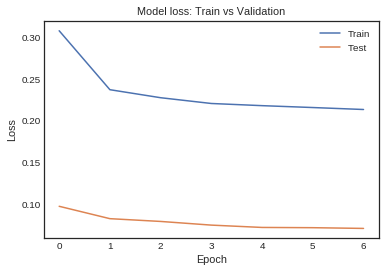

In [21]:
plt.style.use('seaborn-white')
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss: Train vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

#### Prediction on test set

In [18]:
y_pred = model.predict_classes(X_test)
result = accuracy_score(y_test, y_pred)
result

0.980544747081712

#### Prediction on user data

In [ ]:
test_df = pd.Series(["A big part of sadness is feeling really lonely, even if you're in a room full of a million people."])
test_df = test_df.map(lambda x: clean_text(x))
sequences = tokenizer.texts_to_sequences(test_df.values)
X = pad_sequences(sequences, maxlen = MAX_SEQUENCE_LENGTH)
y = model.predict_classes(X)
y

#### Saving model

In [27]:
import pickle

In [30]:
file_pi = open('../depression-tokenizer.pickle', 'wb')
pickle.dump(tokenizer, file_pi)
file_pi.close()

In [31]:
file_p = open('../depression-model.pickle', 'wb') 
pickle.dump(model, file_p)
file_p.close()

In [25]:
pickle_in = open("depression_model.pickle","rb")
example_dict = pickle.load(pickle_in)

/home/yash/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [26]:
y = example_dict.predict_classes(X)

KeyboardInterrupt: 